<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/model_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model for Reviews


In [1]:
!git clone https://github.com/dernameistegal/airbnb_price.git

Cloning into 'airbnb_price'...
remote: Enumerating objects: 1192, done.
remote: Counting objects: 100% (1192/1192), done.
remote: Compressing objects: 100% (1125/1125), done.
remote: Total 1192 (delta 715), reused 316 (delta 58), pack-reused 0
Receiving objects: 100% (1192/1192), 10.07 MiB | 11.70 MiB/s, done.
Resolving deltas: 100% (715/715), done.


In [2]:
%cd airbnb_price
import sys
sys.path.append("/content/airbnb_price/custom_functions")
import general_utils as ut
device = ut.get_device()
#import explainability_utils as explain

/content/airbnb_price
cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla P100-PCIE-16GB


In [3]:
%%capture
!pip install transformers
!pip install requests
!pip install captum

# Data Loading

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import fastprogress
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertModel
import torch.nn as nn
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Explore the dataset

In [5]:
path = "/content/drive/MyDrive/Colab/airbnb/data/reviews/df.pickle"
data = pd.read_pickle(path)
input_ids, attention_masks, labels = data['review_input_ids'], data['review_attention_masks'], data['log_price']

In [6]:
nreviews = np.vectorize(len)(input_ids)

In [7]:
input_ids = np.concatenate(np.array(input_ids))
attention_masks = np.concatenate(np.array(attention_masks))
labels = np.repeat(np.array(labels), nreviews)

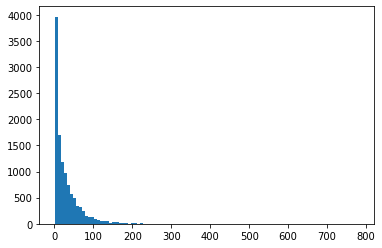

In [8]:
# TODO Visualize the length of the reviews in your dataset
def count_words(string):
    string = string[0]
    return len(string.split())

review_lengths = np.vectorize(count_words)(data["reviews"])

a = plt.hist(review_lengths, bins = 100)
plt.show()

In [9]:
%tensorflow_version 1.x
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

TensorFlow 1.x selected.


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Training, Validation, Test Split

Use 15% of the dataset as validation and test set, respectively. Use the other 70% for training.

In [10]:
train_ids, val_ids, test_ids = ut.train_val_test_split(data.index)  
traindf, valdf = data.loc[train_ids], data.loc[val_ids]
ids_train, labels_train, masks_train = traindf['review_input_ids'], traindf['log_price'], traindf['review_attention_masks']
ids_val, labels_val, masks_val = valdf['review_input_ids'], valdf['log_price'], valdf['review_attention_masks']
nreviews_train = np.vectorize(len)(ids_train)
nreviews_val = np.vectorize(len)(ids_val)

In [11]:
ids_train, ids_val =  np.concatenate(np.array(ids_train)), np.concatenate(np.array(ids_val))
labels_train, labels_val = np.repeat(np.array(labels_train), nreviews_train), np.repeat(np.array(labels_val), nreviews_val)
masks_train, masks_val = np.concatenate(np.array(masks_train)), np.concatenate(np.array(masks_val))

In [12]:
# TODO: Print out the shapes of your splitted train, validation, and test set
# Hint: your validation set should contain 500 samples. How many tokens are
# included per sample? 

# (1) print the feature shapes
print(ids_train.shape)
print(ids_val.shape)

# (2) print the label shapes
print(labels_train.shape)
print(labels_val.shape)

# (3) print the attention mask shapes
print(masks_train.shape)
print(masks_val.shape)

(256285, 128)
(54785, 128)
(256285,)
(54785,)
(256285, 128)
(54785, 128)


## Create DataLoader

You can use `TensorDataset`, `torch.from_numpy(...)`, and `DataLoader(...)` to create Dataloaders for your dataset holding features, labels and attention masks. Make sure to shuffle your training data. Is shuffling required for the validation and test data?

In [13]:
# TODO
# create dataloaders
from torch.utils.data import TensorDataset, DataLoader
trainset = TensorDataset(torch.from_numpy(ids_train), torch.from_numpy(labels_train), torch.from_numpy(masks_train))
valset = TensorDataset(torch.from_numpy(ids_val), torch.from_numpy(labels_val), torch.from_numpy(masks_val))

b = 256
trainloader = DataLoader(trainset, shuffle=True, num_workers=2, batch_size=b)
valloader = DataLoader(valset, shuffle=False, num_workers=2, batch_size=b)

#Fine-tune BERT model

(This is a non-mandatory, fully optional task)

Can you improve performance by fine-tuning BERT in addition to training the readout classifier?

In [ ]:
b = 64
trainloader = DataLoader(trainset, shuffle=True, num_workers=2, batch_size=b)
valloader = DataLoader(valset, shuffle=True, num_workers=2, batch_size=128)
sys.path.append("/content/airbnb_price/models")
from language_model import LanguageBertNet
!mkdir -p /content/checkpoints/
import train_utils as train

In [ ]:
model = LanguageBertNet(fine_tune=True, with_attention_masks=True, cls_dropout_prob=0.5)
model = model.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 25)
result = train.run_training(model, optimizer, loss_fn, device, 50, trainloader, valloader, verbose=True, 
                            scheduler=scheduler, ntrain=50, nval=20)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Saving model...
Saving model...
Saving model...
Saving model...
Saving model...
Saving model...
Saving model...
Saving model...
Saving model...
Saving model...
Saving model...
Finished training after 2048 seconds.


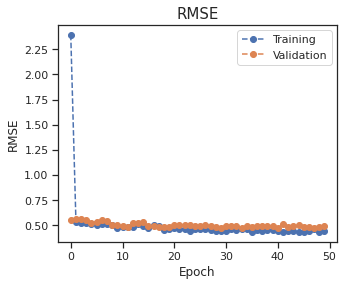

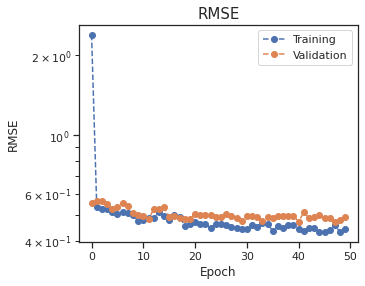

In [ ]:
# plot train and test
train_losses, val_losses, train_rmse, val_rmse = result
plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='linear')
plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='log')

In [ ]:

path ="/content/checkpoints/train_loss.npy"
np.save(path, train_losses)
path ="/content/checkpoints/val_loss.npy"
np.save(path, val_losses)

# do you want to save a checkpoint run this chunk
!mkdir -p /content/drive/MyDrive/Colab/airbnb/data/logs/reviews/best
!cp -r /content/checkpoints/ /content/drive/MyDrive/Colab/airbnb/data/logs/reviews/best

In [ ]:
model.load_state_dict(torch.load("/content/checkpoints/checkpoint.pt"))

<All keys matched successfully>

100%|██████████| 429/429 [06:26<00:00,  1.11it/s]


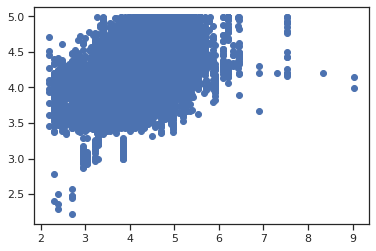

(0.4978482327378353, 0.0)

In [ ]:
# show correlation
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm

ys = []
ypreds = []

with torch.no_grad():
    model = model.eval()

    for ids, labels, masks in tqdm(valloader):
        ids, masks = ids.to(device), masks.to(device)
        y_pred = model(ids, masks)[0]
        y_pred = list(y_pred.detach().cpu().numpy())
        ypreds = ypreds + y_pred

        ys = ys + list(labels)


plt.scatter(ys, ypreds)
plt.show()
pearsonr(ys, ypreds)

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(ys, ypreds)
print("The root mean squared error (MSE) on test set: {:.4f}".format(np.sqrt(mse)))

The root mean squared error (MSE) on test set: 0.4847


In [ ]:
import explainability_utils as explain
text = "This is a modest appartment, with a backyard location in the centre of downtown vienna"
attention = explain.pipeline(text, model, device)
explain.visualize_attention(text, attention)

78.2594223022461


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


# Generate embeddings

In [14]:
# load model
sys.path.append("/content/airbnb_price/models")
from language_model import LanguageBertNet
model = LanguageBertNet(fine_tune=True, with_attention_masks=True)
path = "/content/drive/MyDrive/Colab/airbnb/data/logs/reviews/best/checkpoints/checkpoint.pt"
model.load_state_dict(torch.load(path))
model = model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
input_ids, attention_masks, index = valdf['review_input_ids'], valdf['review_attention_masks'], valdf.index
trainprice, valprice = traindf["log_price"], valdf["log_price"]

1711it [03:29,  8.16it/s]


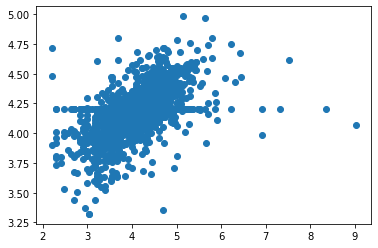

(0.5277922516177301, 2.4664726774232486e-123)
The root mean squared error (MSE) on test set: 0.5789


In [29]:
# show correlation
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm
predictions = torch.empty((len(index)))
model.eval()
indices = []
with torch.no_grad():
    for i, (ids, masks, idx) in tqdm(enumerate(zip(input_ids, attention_masks, index))):
        ls = []
        single_ids, single_masks = torch.tensor(ids).to(device), torch.tensor(masks).to(device)
        embedding = model(single_ids, single_masks)[0]
        embedding = embedding.detach().cpu().numpy()
        predictions[i] = torch.tensor(np.mean(embedding, axis=0))
        indices = indices + [idx]

ys = np.array(valprice)
ypreds = np.array(predictions)
plt.scatter(ys, ypreds)
plt.show()
print(pearsonr(ys, ypreds))


from sklearn.metrics import mean_squared_error

mse = mean_squared_error(ys, ypreds)
print("The root mean squared error (MSE) on test set: {:.4f}".format(np.sqrt(mse)))

In [24]:
ys.shape

(1711,)

In [25]:
ypreds.shape

(11404,)

In [ ]:
# save embeddings in pandas dataframe
df = pd.Series(embeddings.numpy().tolist(), name="reviews", index=indices)
path = "/content/drive/MyDrive/Colab/airbnb/data/embeddings/reviews.pickle"
df.to_pickle(path)

In [ ]:
trainprice, valprice = traindf["log_price"], valdf["log_price"]
dataset = TensorDataset(torch.from_numpy(np.apply_along_axis(np.concatenate, 1, np.array(df.loc[val_ids])[:, np.newaxis])),
                        torch.tensor(valprice.to_numpy()))
dataloader = DataLoader(dataset, batch_size=128)

100%|██████████| 14/14 [00:00<00:00, 67.03it/s]


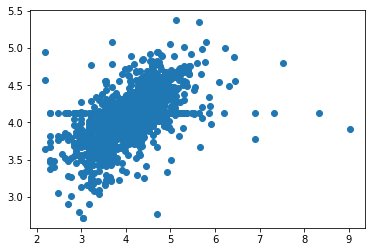

(0.5278151693125199, 2.396696093677349e-123)
The root mean squared error (MSE) on test set: 0.5525


In [ ]:
# show correlation
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm

ys = []
ypreds = []

with torch.no_grad():
    model = model.eval()

    for embeddings, labels in tqdm(dataloader):
        embeddings = embeddings.to(device).float()
        y_pred = model.prediction_from_mean(embeddings)
        y_pred = list(y_pred.detach().cpu())
        ypreds = ypreds + y_pred

        ys = ys + list(labels)

ys = np.array(ys)
ypreds = np.array(ypreds)
m = np.mean(ypreds)
ypreds = (ypreds - np.mean(ypreds)) * 1.6 + np.mean(ypreds)
bias = np.mean(ys) - np.mean(ypreds)
ypreds = ypreds + bias
plt.scatter(ys, ypreds)
plt.show()
print(pearsonr(ys, ypreds))


from sklearn.metrics import mean_squared_error

mse = mean_squared_error(ys, ypreds)
print("The root mean squared error (MSE) on test set: {:.4f}".format(np.sqrt(mse)))

In [ ]:
np.mean(ys) - np.mean(ypreds)

-0.1811590028555612

In [ ]:
df2 = df.copy()

In [ ]:
for i, row in enumerate(df2):
  df2.iloc[i] = [[0 if x < 0 else x for x in row]]

In [ ]:
df

15883       [1.5993396043777466, -0.37486645579338074, -0....
38768       [1.540033221244812, -0.3422797620296478, -0.10...
40625       [1.7504379749298096, -0.5453727841377258, -0.2...
51287       [1.5156196355819702, -0.32791653275489807, -0....
70637       [1.616220474243164, -0.39580944180488586, -0.1...
                                  ...                        
53194341    [1.6022652387619019, -0.35475417971611023, -0....
53194438    [1.6022652387619019, -0.35475417971611023, -0....
53194698    [1.6022652387619019, -0.35475417971611023, -0....
53195075    [1.6022652387619019, -0.35475417971611023, -0....
53198439    [1.6022652387619019, -0.35475417971611023, -0....
Name: reviews, Length: 11404, dtype: object

In [ ]:
path = "/content/drive/MyDrive/Colab/airbnb/data/embeddings/reviews.pickle"
df2.to_pickle(path)

# explainability

In [ ]:
# load model
sys.path.append("/content/airbnb_price/models")
from language_model import LanguageBertNet
model = LanguageBertNet(fine_tune=True, with_attention_masks=True)
path = "/content/drive/MyDrive/Colab/airbnb/data/logs/reviews/best/checkpoints/checkpoint.pt"
model.load_state_dict(torch.load(path))
model = model.to(device)

In [41]:
from captum.attr import visualization
import torch
from transformers import BertTokenizer
import numpy as np


def visualize_attention(text, attention, offset=0):
    ls = []
    for subatt in attention:
        subatt = subatt[0, 0, :, :][:, 0].cpu().numpy()
        ls.append(subatt / np.max(subatt))
    ls = np.array(ls)
    ls = np.sum(ls, axis=0) 
    ls = ls / np.max(ls)
    ls = ls - offset
    vis_data_records = [visualization.VisualizationDataRecord(ls, 0, 0, 0, 0, 0, text.split(), 1)]
    visualization.visualize_text(vis_data_records)

In [51]:
text[6:-6]

'very spacious house. very comfortable rooms with 5 * hotel mattresses. fully equipped kitchen with coffee included..... bright, quiet and very well located. supermarket and bars less than 1 minute. metro 5 minutes walk'

In [55]:
input_ids, price, mask = valset[309]
text = tokenizer.decode(input_ids[mask.bool()])
text = text[6:-6]
print(text)
print(np.exp(price))
# text = "no reviews"
import explainability_utils as explain
attention = explain.pipeline(text, model, device)
attention = attention
visualize_attention(text, attention, offset=0.1)

very spacious house. very comfortable rooms with 5 * hotel mattresses. fully equipped kitchen with coffee included..... bright, quiet and very well located. supermarket and bars less than 1 minute. metro 5 minutes walk
tensor(112.0000, dtype=torch.float64)
89.96533966064453
